In this lab you will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function and optimizer
4. Train the network on the training data
5. Test the network on the test data

Using ``torchvision``, it’s extremely easy to load CIFAR10.



How to install a different version of a package

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Use GPU if available

In [24]:
# Train on Metal GPU (M1)
#train_on_gpu = torch.backends.mps.is_available()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('MPS is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "mps")
print(device)

MPS is available!  Training on GPU ...
cuda


1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
The output of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html#datasets) are PILImage images of range [0, 1].
We [transform](https://pytorch.org/vision/stable/transforms.html) them to Tensors of normalized range [-1, 1]. Then we call the [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)



In [25]:
# Fix for SSL certificate issue with torchvision datasets download
# @see https://stackoverflow.com/a/49174340
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Normalize using mean of 0.5 and std of 0.5 to get a normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 12500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


Train loader:
50000
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}
torch.Size([12500, 3, 32, 32])
cat truck horse ship

Test loader:
10000
{'cat': 1000, 'ship': 1000, 'plane': 1000, 'frog': 1000, 'car': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


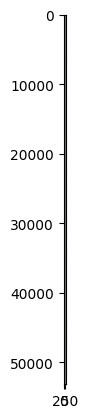

In [26]:
import matplotlib.pyplot as plt  # Import library for plotting
import numpy as np  # Import library for numerical computations
from collections import Counter  # Import Counter for counting elements

# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display

# ------------------ Train Loader Section ------------------

print("Train loader:")

# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

# Print the length of the train loader (number of batches)
print(len(trainset))

# Print the class distribution in the training set
print(new_stat)

# Get a batch of random training images and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the image tensor (batch_size, channels, height, width)
print(images.shape)

# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print the labels of the images
print(' '.join('%s' % classes[labels[j]] for j in range(4)))  # Print labels for 4 images

# ------------------ Test Loader Section ------------------

print("\nTest loader:")

# Similar steps for the test loader
stat = dict(Counter(testset.targets))
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

print(len(testset))
print(new_stat)


2. Define a Convolution Neural Network.
[network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Compute the receptive field of the network

In [28]:
# This line attempts to clone a Git repository using a shell command.
# !git clone https://github.com/Fangyh09/pytorch-receptive-field.git

# This line would move the downloaded directory
#!mv -v pytorch-receptive-field/torch_receptive_field ./
#!ls
# Import the 'receptive_field' function from the 'torch_receptive_field' library.
from torch_receptive_field import receptive_field

# Calculate the receptive field of the network 'net' for an input image size of
# 3 channels (RGB) and 32x32 pixels. The 'receptive_field' function would analyze the network architecture and input size to determine
# the receptive field size for each layer and the overall network.
#receptive_field(net, input_size=(3, 32, 32))


3. Define a loss function and optimizer

Let's use a Classification [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#loss-functions) loss and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum.



In [29]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network on the training data


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [30]:
net.to(device)

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0  
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # move to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.3f}')
    running_loss = 0.0

print('Finished Training')

[1,     4] loss: 2.306
[2,     4] loss: 2.306
[3,     4] loss: 2.306
[4,     4] loss: 2.306
[5,     4] loss: 2.305
[6,     4] loss: 2.305
[7,     4] loss: 2.305
[8,     4] loss: 2.305
[9,     4] loss: 2.305
[10,     4] loss: 2.305
[11,     4] loss: 2.305
[12,     4] loss: 2.305
[13,     4] loss: 2.305
[14,     4] loss: 2.305
[15,     4] loss: 2.305
[16,     4] loss: 2.305
[17,     4] loss: 2.305
[18,     4] loss: 2.305
[19,     4] loss: 2.305
[20,     4] loss: 2.305
[21,     4] loss: 2.305
[22,     4] loss: 2.304
[23,     4] loss: 2.304
[24,     4] loss: 2.304
[25,     4] loss: 2.304
[26,     4] loss: 2.304
[27,     4] loss: 2.304
[28,     4] loss: 2.304
[29,     4] loss: 2.304
[30,     4] loss: 2.304
[31,     4] loss: 2.304
[32,     4] loss: 2.304
[33,     4] loss: 2.304
[34,     4] loss: 2.304
[35,     4] loss: 2.304
[36,     4] loss: 2.304
[37,     4] loss: 2.304
[38,     4] loss: 2.304
[39,     4] loss: 2.303
[40,     4] loss: 2.303
[41,     4] loss: 2.303
[42,     4] loss: 2.303
[

5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.




In [31]:
# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient calculation for better performance during evaluation
with torch.no_grad():
    # Loop over the test loader
    for data in testloader:
        # Get the image and label from the current batch
        image, label = data

        # Move the image data to the specified device (CPU or GPU)
        image = image.to(device)

        # Get the network's prediction for the image
        output = net(image)
        # smax = torch.nn.Softmax(dim=1)(output.cpu())

        # Find the class with the highest probability
        _, predicted = torch.max(output.cpu(), 1)  # Equivalent to pred = torch.argmax(output.cpu(), dim=1)

        # Update total number of test images
        total += label.size(0)  # label.size(0) gives the batch size

        # Count correct predictions
        correct += (predicted == label).sum().item()  # Count true positives

# Calculate and print accuracy
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 8 %


**!HOMEWORK!**

This homework assignment asks you to performs 2 tasks:

1. Analyze Results with Different Network Parameters:

This involves training the network with various configurations of network parameters and analyzing the impact on performance. Here's a step-by-step approach:

**Choose Network Parameters:**

Select the network parameters you want to experiment with. Common choices include:

Number of layers: You can try increasing or decreasing the number of layers in your chosen network architecture (e.g., convolutional layers in a CNN).
Learning rate: Experiment with different learning rates (e.g., 0.01, 0.001, 0.0001) to find a balance between fast learning and stability.
Other parameters: Depending on your network architecture, there might be additional options like:
Number of filters in convolutional layers: This affects the complexity of features extracted from the data.
Activation functions: Experiment with different activation functions (e.g., ReLU, Leaky ReLU) to introduce non-linearity.
Optimizer parameters: Some optimizers (e.g., Adam) have hyperparameters you can adjust.
Train the network for a different number of epochs.

**Analyze Results:**

Compare the performance of the network across different parameter configurations:

How accuracy/loss changes with different parameter values.
2. Show and Explain Errors of the Best Network:

Once you identify the **best performing network configuration** (based on metrics like accuracy or loss), analyze its errors.
For example you can generate a confusion matrix. This matrix visualizes how often the network predicted each class correctly or incorrectly.

Useful resources:
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)



